# Working With Data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [108]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
%matplotlib inline

In [109]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [110]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

# Pandas!

## DataFrame

In [10]:
s = pd.Series(np.random.rand(10), index=np.arange(10, 20))
s

10    0.569887
11    0.422702
12    0.482570
13    0.184841
14    0.511393
15    0.372601
16    0.219535
17    0.777451
18    0.234843
19    0.133041
dtype: float64

In [11]:
print(s.index)
print(s.values)

Int64Index([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')
[0.56988707 0.42270193 0.4825697  0.18484143 0.51139332 0.37260135
 0.2195348  0.77745112 0.23484294 0.133041  ]


In [12]:
s.describe()

count    10.000000
mean      0.390886
std       0.202319
min       0.133041
25%       0.223362
50%       0.397652
75%       0.504187
max       0.777451
dtype: float64

In [13]:
df = pd.DataFrame({'ser1': s, 'ser2': np.random.randn(10)})
df.head()

,ser1,ser2
10,0.569887,-0.366604
11,0.422702,-0.217026
12,0.482570,0.458361
13,0.184841,0.811349
14,0.511393,-0.359964


In [14]:
df.describe()

,ser1,ser2
count,10.000000,10.000000
mean,0.390886,0.029889
std,0.202319,0.522362
min,0.133041,-0.604634
25%,0.223362,-0.364944
50%,0.397652,-0.032469
75%,0.504187,0.427407
max,0.777451,0.811349


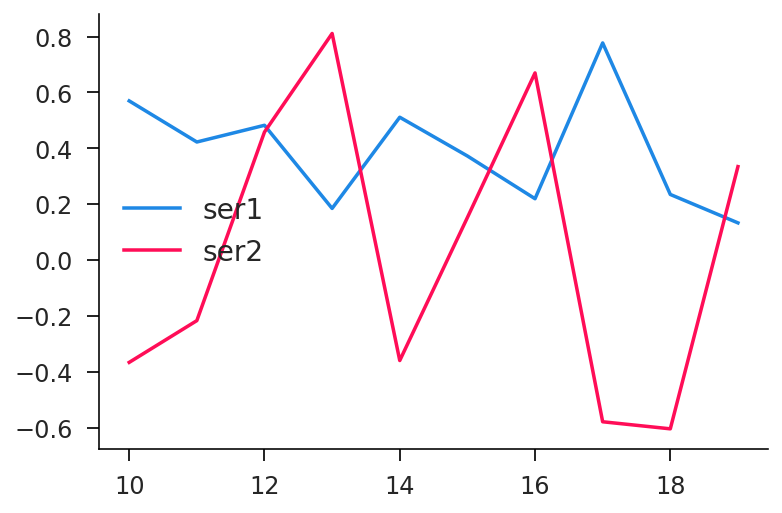

In [15]:
df.plot();

In [16]:
df['ser1']

10    0.569887
11    0.422702
12    0.482570
13    0.184841
14    0.511393
15    0.372601
16    0.219535
17    0.777451
18    0.234843
19    0.133041
Name: ser1, dtype: float64

In [17]:
df['ser1'] > 0.5

10     True
11    False
12    False
13    False
14     True
15    False
16    False
17     True
18    False
19    False
Name: ser1, dtype: bool

In [18]:
df1 = df[df['ser1']>0.5]
df1

,ser1,ser2
10,0.569887,-0.366604
14,0.511393,-0.359964
17,0.777451,-0.579308


In [19]:
df.query('ser1 > 0.5')

,ser1,ser2
10,0.569887,-0.366604
14,0.511393,-0.359964
17,0.777451,-0.579308


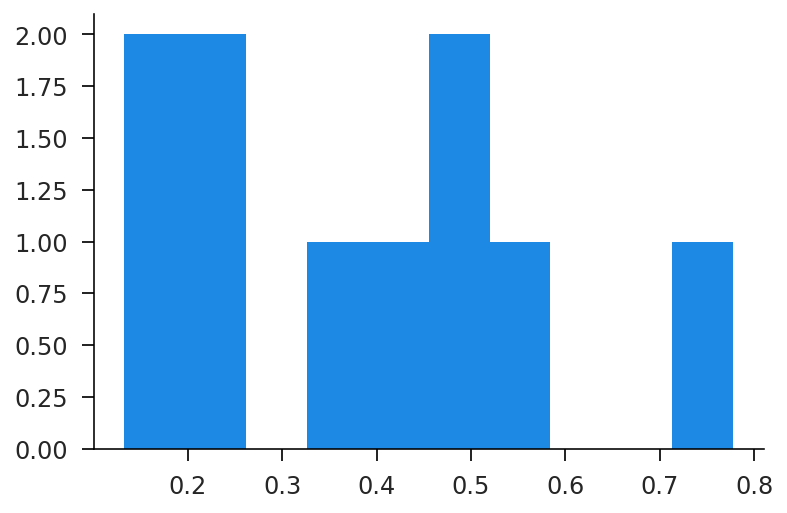

In [20]:
df['ser1'].hist(grid=False);

## Grouping Data

In [21]:
# make some fake data
N = 100
block = np.random.randint(4, size=N)
cmean = np.array([0.1, 0.2, 0.3, 0.4])
cvars = np.array([0.2, 0.1, 0.5, 0.2])
value = cmean[block]+np.random.randn(N)*cvars[block]
df = pd.DataFrame({
    'block': block,
    'value': value
})

In [22]:
df.head(10)

,block,value
0,3,0.043708
1,1,0.256855
2,3,0.280304
3,3,0.519445
4,2,0.415842
5,0,0.245953
6,3,0.349596
7,2,0.364997
8,0,-0.083851
9,3,0.504746


In [23]:
df.groupby('block').size()

block
0    25
1    21
2    29
3    25
dtype: int64

In [24]:
df.groupby('block')['value'].mean()

block
0    0.087766
1    0.192139
2    0.403995
3    0.423666
Name: value, dtype: float64

In [25]:
df.groupby('block')['value'].std()

block
0    0.193500
1    0.111814
2    0.518592
3    0.188940
Name: value, dtype: float64

In [26]:
df.groupby('block')['value'].apply(lambda x: np.mean(np.abs(x-np.mean(x))))

block
0    0.155865
1    0.088209
2    0.403261
3    0.147893
Name: value, dtype: float64

In [27]:
grp = df.groupby('block')['value']
pd.DataFrame({
    'mean': grp.mean(),
    'stdv': grp.std(),
    'absd': grp.apply(lambda x: np.mean(np.abs(x-np.mean(x))))
})

,mean,stdv,absd
block,,,
0,0.087766,0.193500,0.155865
1,0.192139,0.111814,0.088209
2,0.403995,0.518592,0.403261
3,0.423666,0.188940,0.147893


## Time Series

In [28]:
ret = 0.05 # yearly return
vol = 0.1 # yearly volatility

In [29]:
days = pd.date_range('2016-01-01', '2016-12-31', freq='D')
N = len(days)
T = (days.max()-days.min()).days/365.25
delt = T/N

In [30]:
vals = vol*np.sqrt(delt)*np.cumsum(np.random.randn(N))
df = pd.DataFrame({
    'date': days,
    'price': vals
}).set_index('date')
df.head()

,price
date,
2016-01-01,-0.003513
2016-01-02,0.003011
2016-01-03,0.000497
2016-01-04,-0.005433
2016-01-05,0.004224


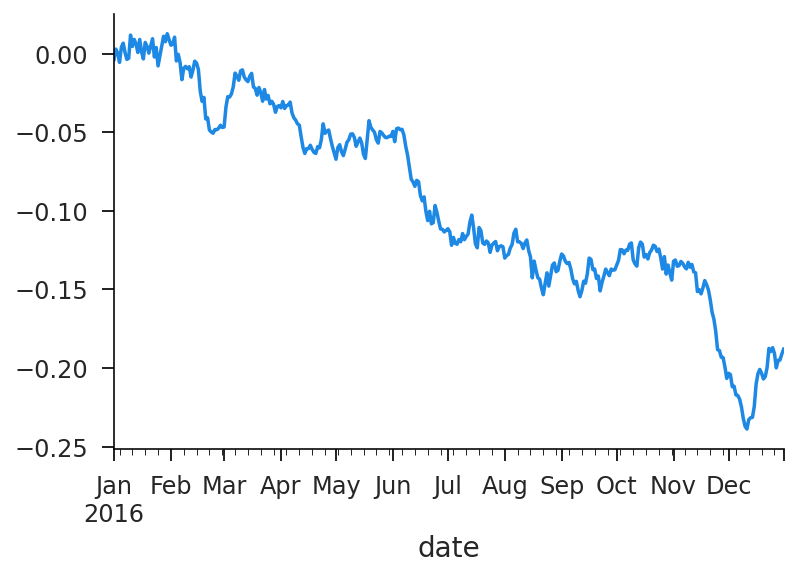

In [31]:
df['price'].plot();

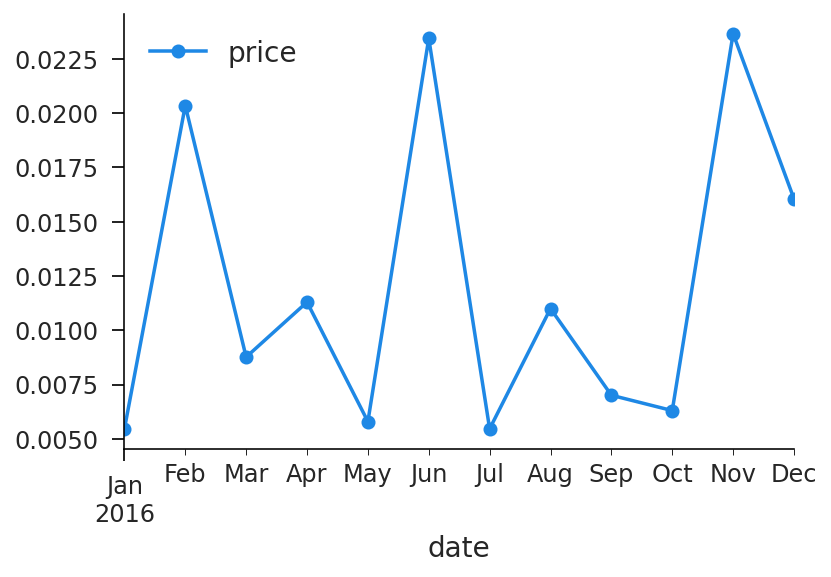

In [32]:
df.groupby(pd.Grouper(freq='MS')).std().plot(marker='o');

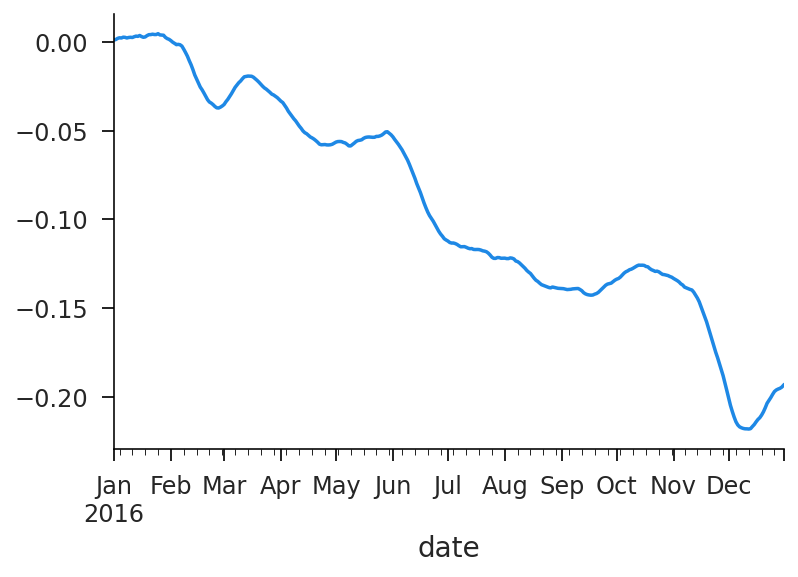

In [33]:
df.rolling(20, center=True, min_periods=5).mean().plot(legend=False);

## Transforming

In [34]:
ret = 0.05 # yearly return
vol = 0.1 # yearly volatility

In [35]:
days = pd.date_range('2006-01-01', '2016-12-31', freq='D')
N = len(days)
T = (days.max()-days.min()).days/365.25
delt = T/N

In [36]:
vals = vol*np.sqrt(delt)*np.cumsum(np.random.randn(len(days)))
df = pd.DataFrame({
    'date': days,
    'price': vals
}).set_index('date')

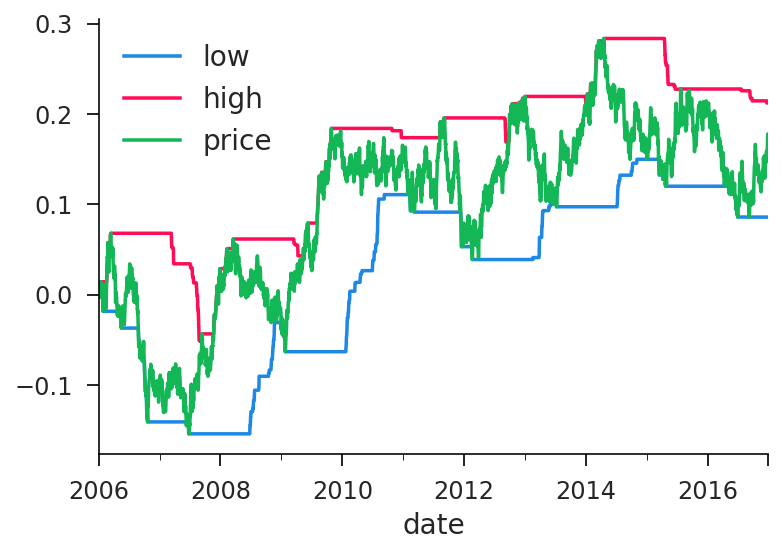

In [37]:
roll = df['price'].rolling(52*7, min_periods=1)
pd.DataFrame({
    'low' : roll.min(),
    'high': roll.max(),
    'price': df['price']
}).plot();

## Plotting

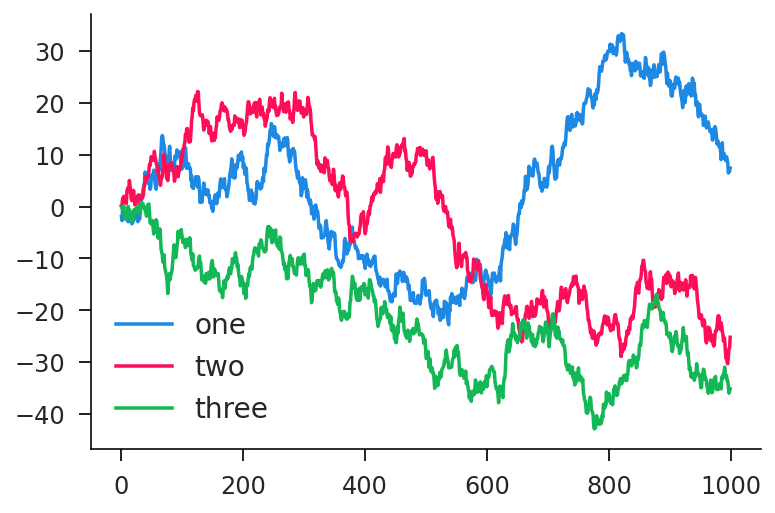

In [38]:
# good way to arrange plots
pd.DataFrame({
    'one': np.cumsum(np.random.randn(1000)),
    'two': np.cumsum(np.random.randn(1000)),
    'three': np.cumsum(np.random.randn(1000))
}).plot();

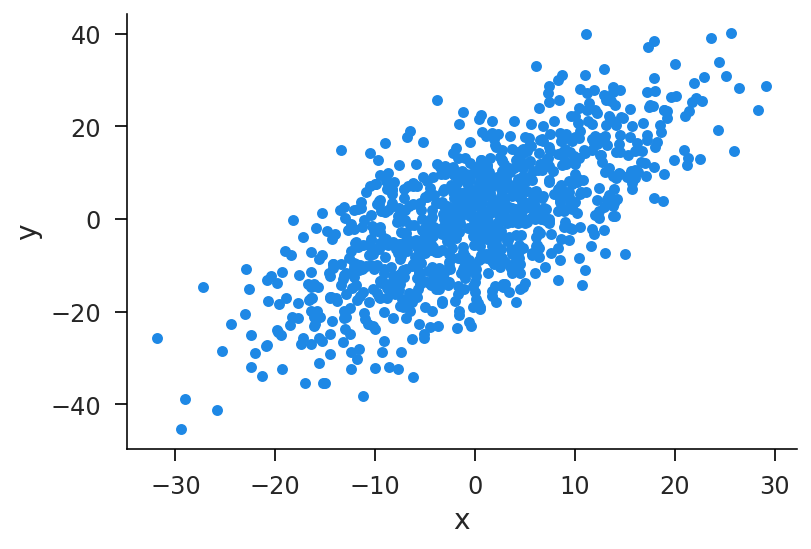

In [39]:
x = 10*np.random.randn(1000)
y = x + 10*np.random.randn(1000)
df = pd.DataFrame({
    'x': x,
    'y': y
})
df.plot.scatter(x='x', y='y');

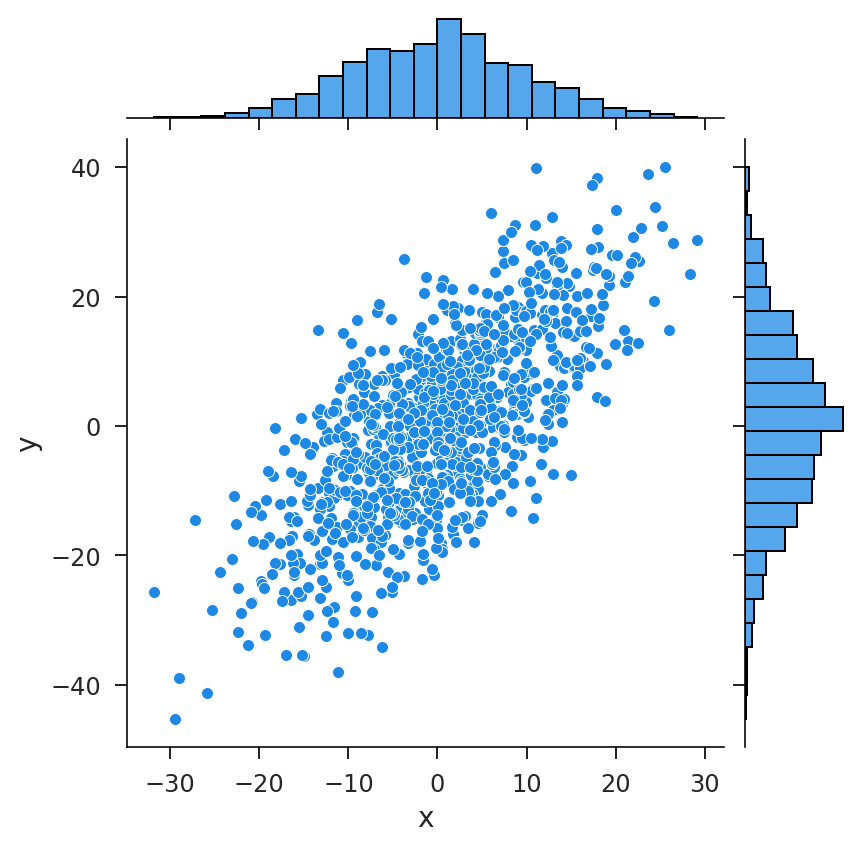

In [40]:
sns.jointplot('x', 'y', data=df);

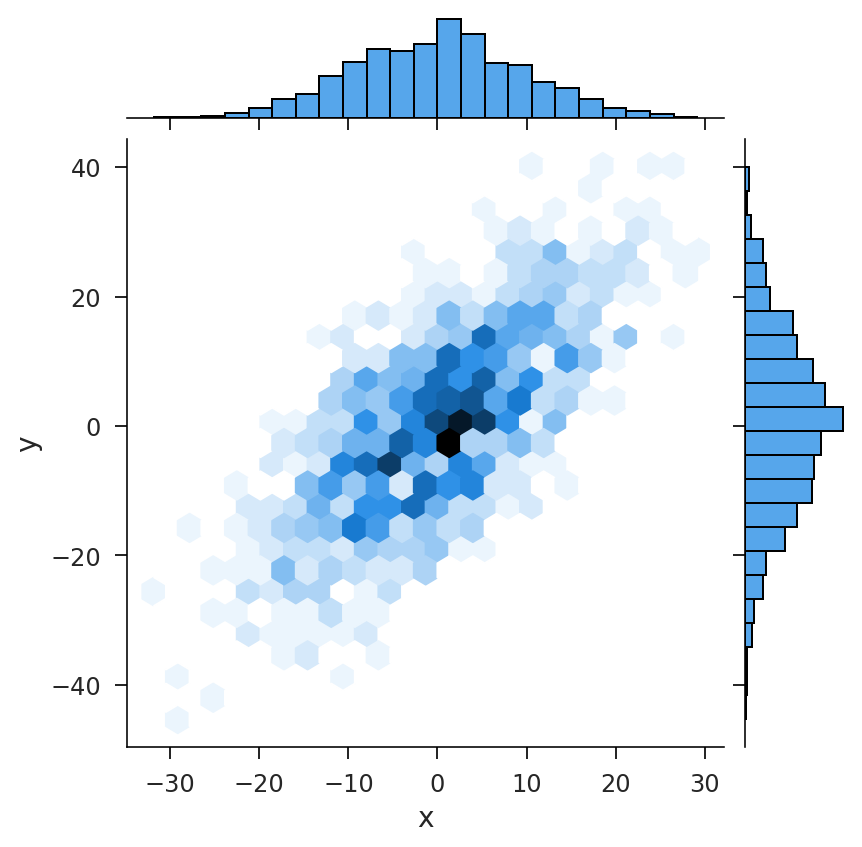

In [41]:
# kind in ['scatter', 'reg', 'resid', 'kde', 'hex']
sns.jointplot('x', 'y', kind='hex', data=df);

## Indexing

In [42]:
df = pd.DataFrame({
    'a': np.arange(10),
    'b': np.random.rand(10)
}, index=np.arange(10, 20))
df

,a,b
10,0,0.182559
11,1,0.946501
12,2,0.060210
13,3,0.605039
14,4,0.055991
15,5,0.706039
16,6,0.769997
17,7,0.138235
18,8,0.094212
19,9,0.105282


In [43]:
# slicing on index
df.loc[14]

a    4.000000
b    0.055991
Name: 14, dtype: float64

In [44]:
# slicing on location
df.iloc[4]

a    4.000000
b    0.055991
Name: 14, dtype: float64

In [45]:
# slicing on column
df['a']

10    0
11    1
12    2
13    3
14    4
15    5
16    6
17    7
18    8
19    9
Name: a, dtype: int64

In [46]:
# selecting
df[df['a']>5]

,a,b
16,6,0.769997
17,7,0.138235
18,8,0.094212
19,9,0.105282


In [47]:
# advanced selecting
df[(df['a']>3)&(df['a']<8)]

,a,b
14,4,0.055991
15,5,0.706039
16,6,0.769997
17,7,0.138235


In [48]:
# selection mechanism
df['a'] > 3

10    False
11    False
12    False
13    False
14     True
15     True
16     True
17     True
18     True
19     True
Name: a, dtype: bool

In [49]:
# querying
df.query('a > 3 and a < 8')

,a,b
14,4,0.055991
15,5,0.706039
16,6,0.769997
17,7,0.138235


## Joining

In [50]:
mapp = pd.Series({x: 2*x for x in range(10)}, name='twox')
mapp

0     0
1     2
2     4
3     6
4     8
5    10
6    12
7    14
8    16
9    18
Name: twox, dtype: int64

In [51]:
init = pd.DataFrame({
    'ser': np.random.randint(10, size=100),
    'val': np.random.rand(100)
})
init.head()

,ser,val
0,6,0.620127
1,2,0.226289
2,7,0.168371
3,8,0.031972
4,1,0.022978


In [52]:
final = init.join(mapp, on='ser')
final.head()

,ser,val,twox
0,6,0.620127,12
1,2,0.226289,4
2,7,0.168371,14
3,8,0.031972,16
4,1,0.022978,2


In [53]:
final['check'] = final['twox'] == 2*final['ser']
final.head()

,ser,val,twox,check
0,6,0.620127,12,True
1,2,0.226289,4,True
2,7,0.168371,14,True
3,8,0.031972,16,True
4,1,0.022978,2,True


In [54]:
print(final['check'].all())

True


### Stack and unstack (and some pivot)

In [55]:
a = [0, 1, 2]
b = [1, 2, 3]
list(zip(a, b))

[(0, 1), (1, 2), (2, 3)]

In [56]:
# this constructs a family structure table
M, N = 5, 12
from itertools import cycle
cmap = list(zip(cycle(range(M)), range(100, 100+N), np.random.rand(N)))
pmap = pd.DataFrame(cmap, columns=['pid', 'cid', 'income'])
pmap = pmap.sort_values('pid').reset_index(drop=True)
pmap

,pid,cid,income
0,0,100,0.946569
1,0,105,0.992487
2,0,110,0.609330
3,1,101,0.378906
4,1,106,0.879807
5,1,111,0.074789
6,2,102,0.360355
7,2,107,0.486946
8,3,103,0.591502
9,3,108,0.436361


In [57]:
# tabulate the order of each child
pmap['order'] = pmap.groupby('pid').cumcount().apply(lambda x: f'child{x}')
ptab = pmap.set_index(['pid', 'order'])
ptab

cid    income
pid order                
0   child0  100  0.946569
    child1  105  0.992487
    child2  110  0.609330
1   child0  101  0.378906
    child1  106  0.879807
    child2  111  0.074789
2   child0  102  0.360355
    child1  107  0.486946
3   child0  103  0.591502
    child1  108  0.436361
4   child0  104  0.067265
    child1  109  0.460365

In [58]:
fam = ptab.unstack(level=1)
fam

cid                  income                    
order child0 child1 child2    child0    child1    child2
pid                                                     
0      100.0  105.0  110.0  0.946569  0.992487  0.609330
1      101.0  106.0  111.0  0.378906  0.879807  0.074789
2      102.0  107.0    NaN  0.360355  0.486946       NaN
3      103.0  108.0    NaN  0.591502  0.436361       NaN
4      104.0  109.0    NaN  0.067265  0.460365       NaN

In [59]:
# the reverse operation gives us (almost) what we started with
fam.stack(level='order')

cid    income
pid order                  
0   child0  100.0  0.946569
    child1  105.0  0.992487
    child2  110.0  0.609330
1   child0  101.0  0.378906
    child1  106.0  0.879807
    child2  111.0  0.074789
2   child0  102.0  0.360355
    child1  107.0  0.486946
3   child0  103.0  0.591502
    child1  108.0  0.436361
4   child0  104.0  0.067265
    child1  109.0  0.460365

In [60]:
# we can do this with pivot too
ptab.reset_index().pivot('pid', 'order', ['cid', 'income'])

cid                  income                    
order child0 child1 child2    child0    child1    child2
pid                                                     
0      100.0  105.0  110.0  0.946569  0.992487  0.609330
1      101.0  106.0  111.0  0.378906  0.879807  0.074789
2      102.0  107.0    NaN  0.360355  0.486946       NaN
3      103.0  108.0    NaN  0.591502  0.436361       NaN
4      104.0  109.0    NaN  0.067265  0.460365       NaN

## Networks

In [61]:
import networkx as nx

In [62]:
df = pd.DataFrame({
    'src': np.random.randint(10, size=20),
    'dst': np.random.randint(10, size=20),
    'wgt': np.random.exponential(size=20)
})
df = df.drop_duplicates(subset=['src', 'dst'])
df = df.query('src != dst')
df.head()

,src,dst,wgt
0,1,6,6.528494
1,5,4,3.443756
2,5,8,0.259181
3,8,2,0.206307
4,2,5,0.557460


In [63]:
G = nx.Graph()
G.add_nodes_from(np.arange(10))
G.add_weighted_edges_from([(x['src'], x['dst'], x['wgt']) for i, x in df.iterrows()])
# G.add_weighted_edges_from(df[['src', 'dst', 'wgt']].values) # equivalent
G

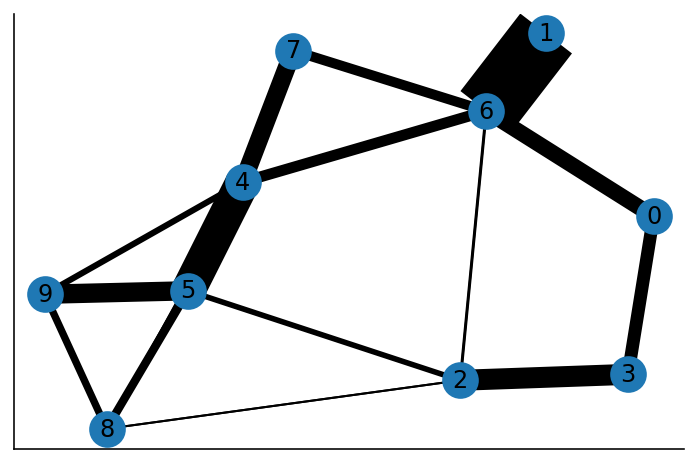

In [64]:
edgewidth = [5*d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, iterations=50)
nx.draw_networkx(G, pos);
nx.draw_networkx_edges(G, pos, width=edgewidth);

In [65]:
nx.centrality.eigenvector.eigenvector_centrality(G, weight='weight')

{0: 0.16312536072251863,
 1: 0.6381644606807226,
 2: 0.054217120292731714,
 3: 0.04614369350307617,
 4: 0.21390946666115723,
 5: 0.12788248243645636,
 6: 0.6868928750144968,
 7: 0.15238284919977413,
 8: 0.026641787955491592,
 9: 0.056605411821921636}

## Input/Output

In [66]:
df = pd.DataFrame({
    'one': np.cumsum(np.random.randn(1000)),
    'two': np.cumsum(np.random.randn(1000)),
    'three': np.cumsum(np.random.randn(1000))
})
df.to_csv('output/series.csv', index=False)

In [67]:
!head output/series.csv

one,two,three
-0.08382751209141469,-0.6392368772680203,-0.2930113100544169
1.5504359874924918,-0.5263616348263853,-1.190398654705744
1.4393106505173148,0.08461433066362845,-2.1200587550159433
0.6678078750425654,0.0518892754861291,-1.5280464648454455
0.5125921035457255,-0.6927973761120126,-0.7684181482920883
0.5762286003172763,-0.42488621317284453,-1.5453408522949919
1.2028133708939965,-0.17957024791309575,-1.2106053123036027
1.5952465643801028,-1.913375059296561,-1.3843334711593476
3.310274569145378,-0.8754120196901065,-1.8709791008209729


In [68]:
df = pd.read_csv('output/series.csv')
df.head()

,one,two,three
0,-0.083828,-0.639237,-0.293011
1,1.550436,-0.526362,-1.190399
2,1.439311,0.084614,-2.120059
3,0.667808,0.051889,-1.528046
4,0.512592,-0.692797,-0.768418


Can also use the many `pd.DataFrame.to_*` and `pd.read_*` function where `*` is one of:
- csv
- excel
- json
- html
- latex
- stata
- sql

## External Data

In [69]:
import pandas_datareader as pdr

In [70]:
emp = pdr.fred.FredReader(['UNRATE', 'LNS12300060'], start='1948-01-01').read()
emp = emp.rename(columns={'UNRATE': 'unemp', 'LNS12300060': 'empop'}).rename_axis('date')
emp.head()

,unemp,empop
date,,
1948-01-01,3.4,62.6
1948-02-01,3.8,62.7
1948-03-01,4.0,62.6
1948-04-01,3.9,62.9
1948-05-01,3.5,62.5


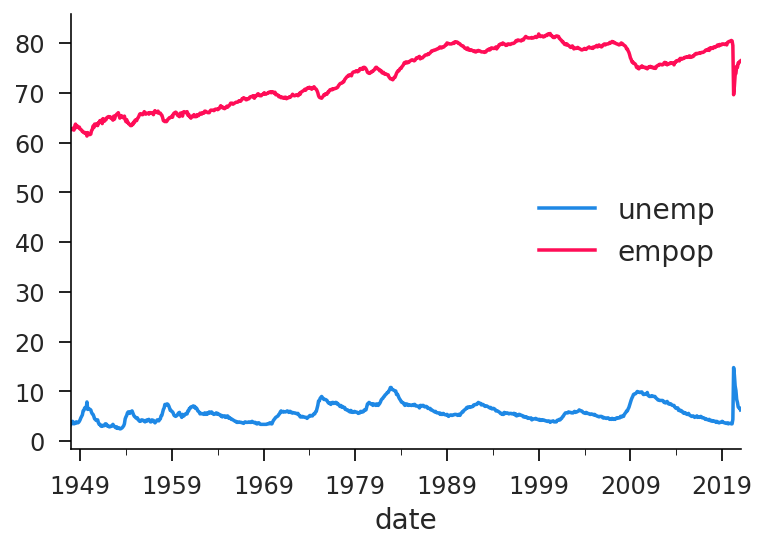

In [71]:
emp.plot();

In [72]:
# detrender
def detrend(s):
    name = s.name
    df = s.reset_index()
    df['year'] = df['date'].dt.year
    ret = smf.ols(f'{name} ~ 1 + year', data=df.reset_index()).fit()
    pred = pd.Series(ret.predict(), index=s.index)
    return s - pred

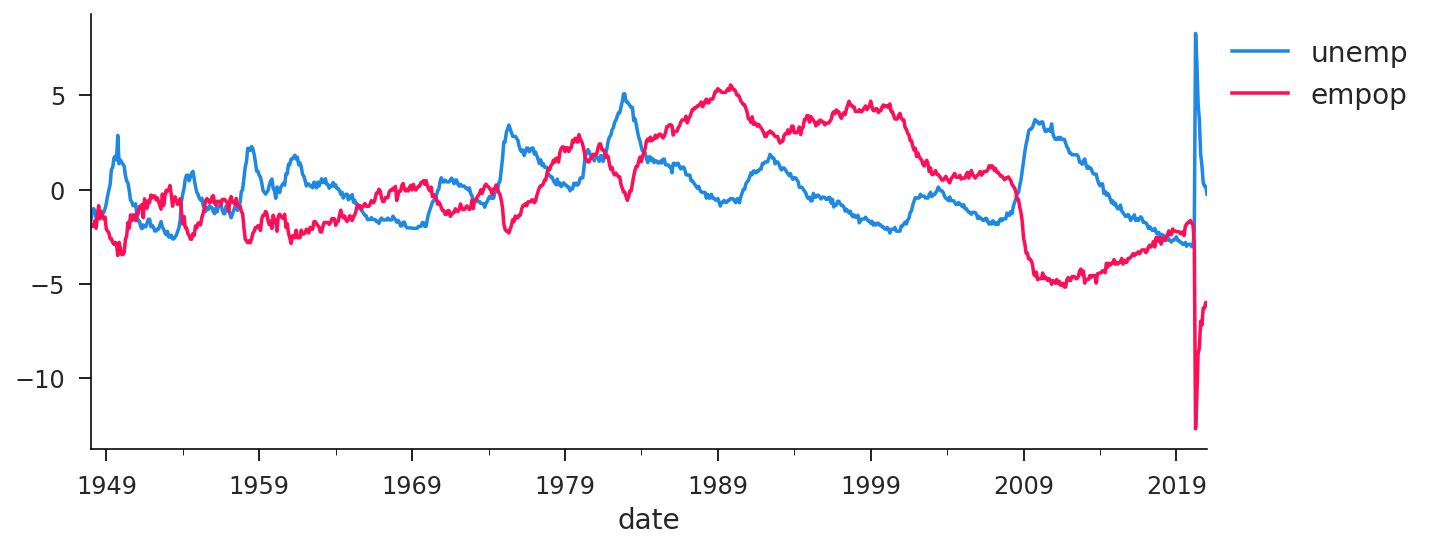

In [73]:
emp.apply(detrend).plot(figsize=(10, 4));
plt.legend(bbox_to_anchor=(1.0, 1.0));

In [74]:
# detrend poly!
def detrendn(s, deg=1):
    name = s.name
    df = s.reset_index()
    df['year'] = df['date'].dt.year
    df['zyear'] = df['year'] - df['year'].min()
    reg = []
    for n in range(deg+1):
        ds = f'year{n}'
        df[ds] = df['zyear']**n
        reg.append(ds)
    reg = f'{name} ~ ' + ' + '.join(reg)
    ret = smf.ols(reg, data=df).fit()
    pred = pd.Series(ret.predict(), index=s.index)
    return s - pred

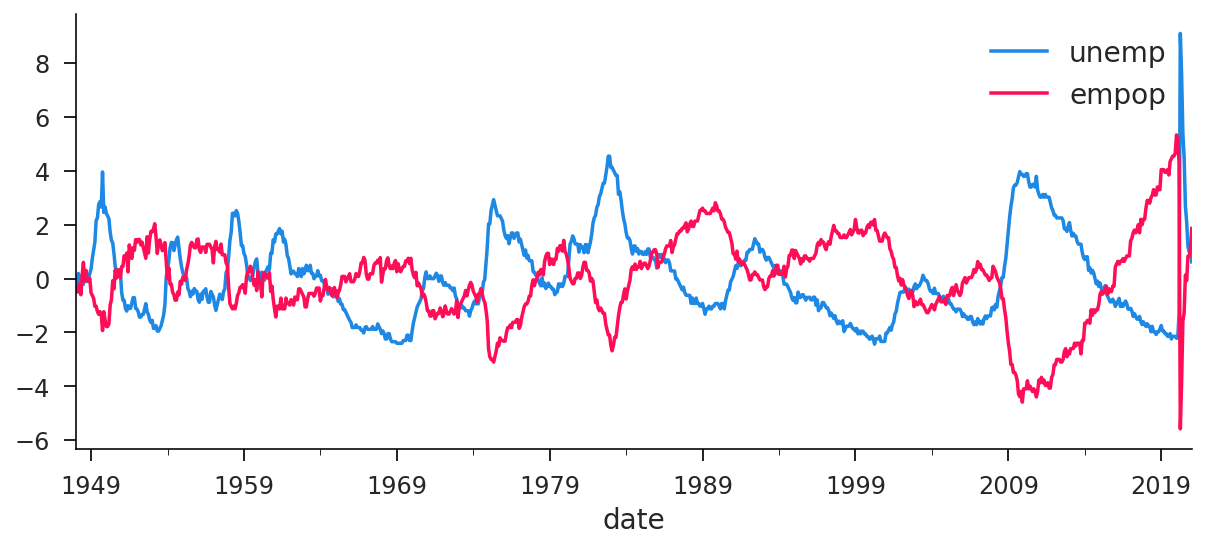

In [75]:
emp.apply(lambda s: detrendn(s, deg=3)).plot(figsize=(10, 4));
plt.legend(bbox_to_anchor=(1.0, 1.0));

In [76]:
# let's not reinvent the wheel
def detrendn1(s, deg=1):
    year = s.index.year
    zyear = year - year.min()
    coef = np.polyfit(zyear, s, deg)
    vals = np.polyval(coef, zyear)
    pred = pd.Series(vals, index=s.index, name=s.name)
    return s - pred

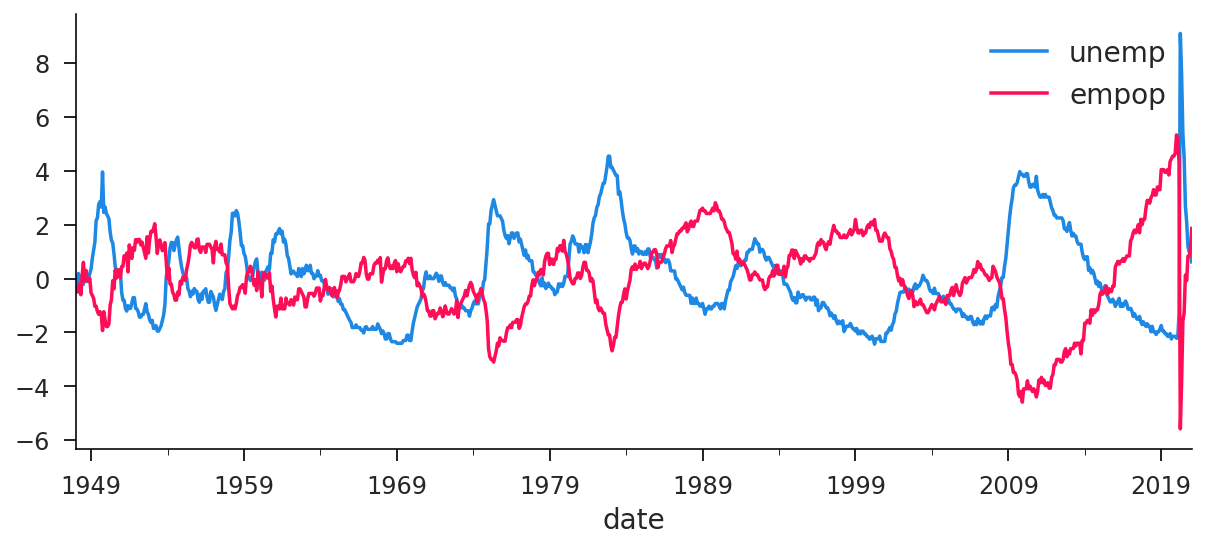

In [77]:
emp.apply(lambda s: detrendn1(s, deg=3)).plot(figsize=(10, 4));
plt.legend(bbox_to_anchor=(1.0, 1.0));

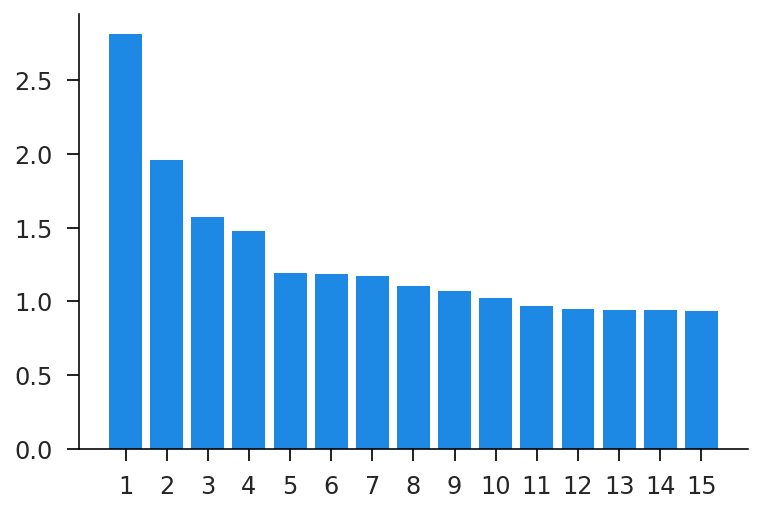

In [78]:
dvec = np.arange(1, 15+1)
plt.bar(dvec, [np.std(detrendn1(emp['empop'], deg=d)) for d in dvec]);
plt.xticks(dvec);

# Regressions

In [79]:
import statsmodels.formula.api as smf

## Basic

In [80]:
N = 100
x = np.random.randn(N)
y = 3*np.random.randn(N)
z = 1 + 2*x + 3*y + 4*x*y + np.random.randn(N)
df = pd.DataFrame({
    'x': x,
    'y': y,
    'z': z
})

In [81]:
ret = smf.ols('z ~ 1 + x + y', data=df).fit()
ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      z   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     22.49
Date:                Wed, 03 Mar 2021   Prob (F-statistic):           9.43e-09
Time:                        08:53:26   Log-Likelihood:                -409.72
No. Observations:                 100   AIC:                             825.4
Df Residuals:                      97   BIC:                             833.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4422      1.508     -0.957      0.341      -4.434       1.550
x             -3.6156      1.556     -2.323      0.022      -6.704      -0.527
y              2.7829      0.465      5.988      0.000       1.861       3.705
==============================================================================
Omnibus:                       82.826   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              911.194
Skew:                          -2.501   Prob(JB):                    1.37e-198
Kurtosis:                      16.917   Cond. No.                         3.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
ret.params

Intercept   -1.442208
x           -3.615646
y            2.782923
dtype: float64

In [83]:
ret = smf.ols('z ~ 1 + x*y', data=df).fit()
ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      z   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     9873.
Date:                Wed, 03 Mar 2021   Prob (F-statistic):          2.20e-119
Time:                        08:53:26   Log-Likelihood:                -142.02
No. Observations:                 100   AIC:                             292.0
Df Residuals:                      96   BIC:                             302.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7228      0.105      6.863      0.000       0.514       0.932
x              2.0400      0.115     17.785      0.000       1.812       2.268
y              3.0313      0.032     94.218      0.000       2.967       3.095
x:y            3.9996      0.028    142.139      0.000       3.944       4.055
==============================================================================
Omnibus:                        2.796   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.281
Skew:                          -0.214   Prob(JB):                        0.320
Kurtosis:                       3.603   Cond. No.                         4.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

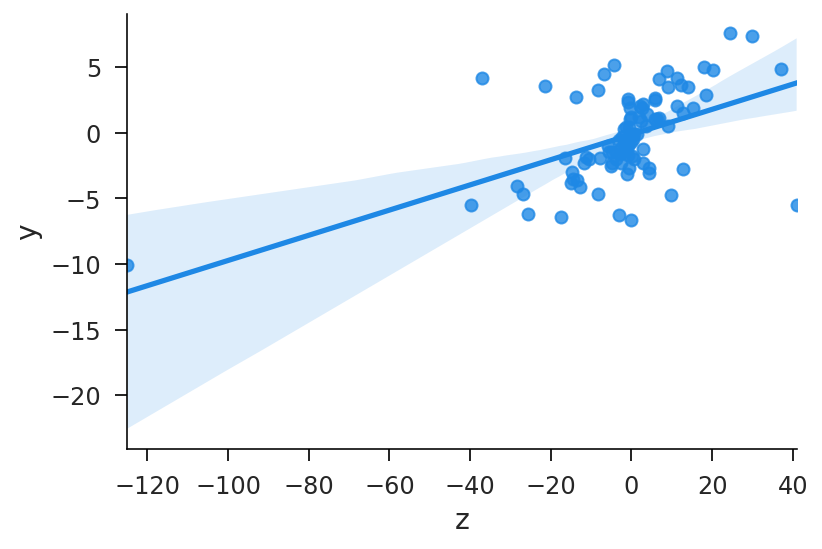

In [84]:
sns.regplot('z', 'y', data=df);

## Categorical

In [85]:
# make some fake data
N = 100
block = np.random.randint(4, size=N)
cmean = np.array([0.1, 0.2, 0.3, 0.4])
cvars = np.array([0.2, 0.1, 0.5, 0.2])
value = cmean[block] + np.random.randn(N)*cvars[block]
df = pd.DataFrame({
    'block': block,
    'value': value
})

In [86]:
ret = smf.ols('value ~ 0 + C(block)', data=df).fit()
ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     5.290
Date:                Wed, 03 Mar 2021   Prob (F-statistic):            0.00203
Time:                        08:53:28   Log-Likelihood:                -17.987
No. Observations:                 100   AIC:                             43.97
Df Residuals:                      96   BIC:                             54.39
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
C(block)[0]     0.1004      0.060      1.664      0.099      -0.019       0.220
C(block)[1]     0.2090      0.058      3.605      0.000       0.094       0.324
C(block)[2]     0.2978      0.059      5.037      0.000       0.180       0.415
C(block)[3]     0.4240      0.059      7.172      0.000       0.307       0.541
==============================================================================
Omnibus:                       13.166   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               32.378
Skew:                          -0.351   Prob(JB):                     9.32e-08
Kurtosis:                       5.698   Cond. No.                         1.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
ret.params - cmean

C(block)[0]    0.000437
C(block)[1]    0.008987
C(block)[2]   -0.002159
C(block)[3]    0.024027
dtype: float64

In [88]:
stderr_reg = np.sqrt(ret.cov_params().values.diagonal())
stderr_rob = np.sqrt(ret.cov_HC0.diagonal())

## Bootstrapping

In [89]:
from sklearn.utils import resample

In [90]:
def gen_block_data(N, cmean, cvars):
    cmean = np.array(cmean)
    cvars = np.array(cvars)
    block = np.random.randint(len(cmean), size=N)
    value = cmean[block] + np.random.randn(N)*cvars[block]
    return pd.DataFrame({
        'block': block,
        'value': value
    })

In [91]:
N = 100
K = 1000
cmean = [0.1, 0.2, 0.3, 0.4]
cvars = [0.2, 0.1, 0.5, 0.2]
mygen = lambda: gen_block_data(N, cmean, cvars)
myeqn = 'value ~ 0 + C(block)'
data0 = mygen()
mysamp = lambda: resample(data0)

In [92]:
res = pd.DataFrame({i: smf.ols(myeqn, data=mygen()).fit().params for i in range(K)}).T
res.columns = ['b0', 'b1', 'b2', 'b3']
stderr_bsp0 = res.std().values

In [93]:
res = pd.DataFrame({i: smf.ols(myeqn, data=mysamp()).fit().params for i in range(K)}).T
res.columns = ['b0', 'b1', 'b2', 'b3']
stderr_bsp = res.std().values

In [94]:
pd.DataFrame({
    'stderr_reg': stderr_reg,
    'stderr_rob': stderr_rob,
    'stderr_bsp0': stderr_bsp0,
    'stderr_bsp': stderr_bsp
}).T

,0,1,2,3
stderr_reg,0.060345,0.057977,0.059125,0.059125
stderr_rob,0.037564,0.021084,0.098848,0.043263
stderr_bsp0,0.042311,0.019719,0.101676,0.040535
stderr_bsp,0.037742,0.018458,0.082288,0.037775


In [95]:
(2*(1/(stderr_bsp0/cvars)))**2/N

array([0.89373546, 1.02872897, 0.96731333, 0.97376725])

## MAPS

In [96]:
import geopandas as gpd
from ipywidgets import interact, IntSlider

In [97]:
pref_hist = gpd.read_file('/media/totoro/data/china_maps/history/v6_time_pref_pgn_utf_wgs84.shp')
pref_hist = pref_hist.rename(columns={
    'NAME_CH': 'name_zh',
    'NAME_PY': 'name_en',
    'BEG_YR': 'beg_yr',
    'END_YR': 'end_yr'
})[['name_zh', 'name_en', 'beg_yr', 'end_yr', 'geometry']]
print(len(pref_hist))
pref_hist.head()

3830


,name_zh,name_en,beg_yr,end_yr,geometry
0,辽州,Liao Zhou,1151,1217,"POLYGON ((113.54941 36.75454, 113.54329 36.752..."
1,沁州,Qin Zhou,1129,1217,"MULTIPOLYGON (((112.00320 36.84234, 112.00954 ..."
2,霍州,Huo Zhou,1772,1911,"MULTIPOLYGON (((111.85910 36.44626, 111.86777 ..."
3,南泽州,Nanzhe Zhou,1128,1150,"POLYGON ((113.23645 35.44530, 113.22804 35.444..."
4,泽州,Zezhou Fu,1151,1217,"POLYGON ((113.23645 35.44530, 113.22804 35.444..."


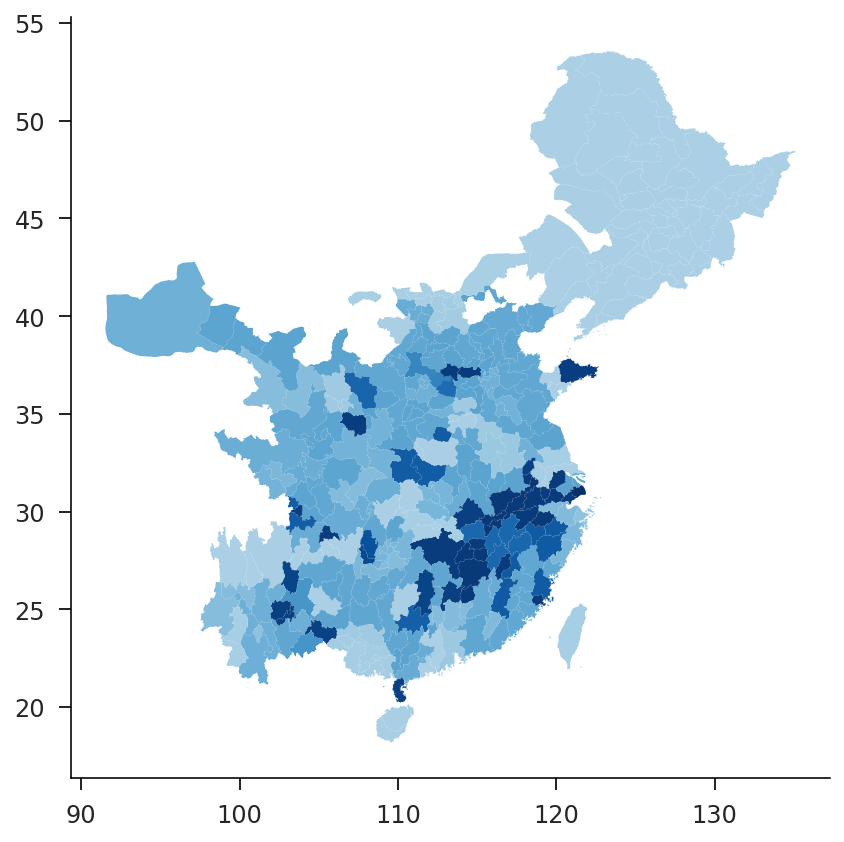

In [98]:
pref_1911 = pref_hist.query('beg_yr < 1911 and end_yr >= 1911')
pref_1911.plot(column='beg_yr', cmap='Blues_r', vmax=2200, figsize=(7, 7));

In [99]:
def plot_year(yr):
    df = pref_hist.query(f'beg_yr <= {yr} and end_yr >= {yr}')
    df['age'] = yr - df['beg_yr']
    yrmax = df['age'].max()
    fig, ax = plt.subplots(figsize=(7, 7))
    df.plot(column='age', cmap='Blues', ax=ax, vmin=-100, vmax=600);
    ax.set_xlim(85, 135)
    ax.set_ylim(15, 50)
    ax.set_aspect('equal')
interact(plot_year, yr=IntSlider(min=-224, max=1911, value=1900));

interactive(children=(IntSlider(value=1900, description='yr', max=1911, min=-224), Output()), _dom_classes=('w…

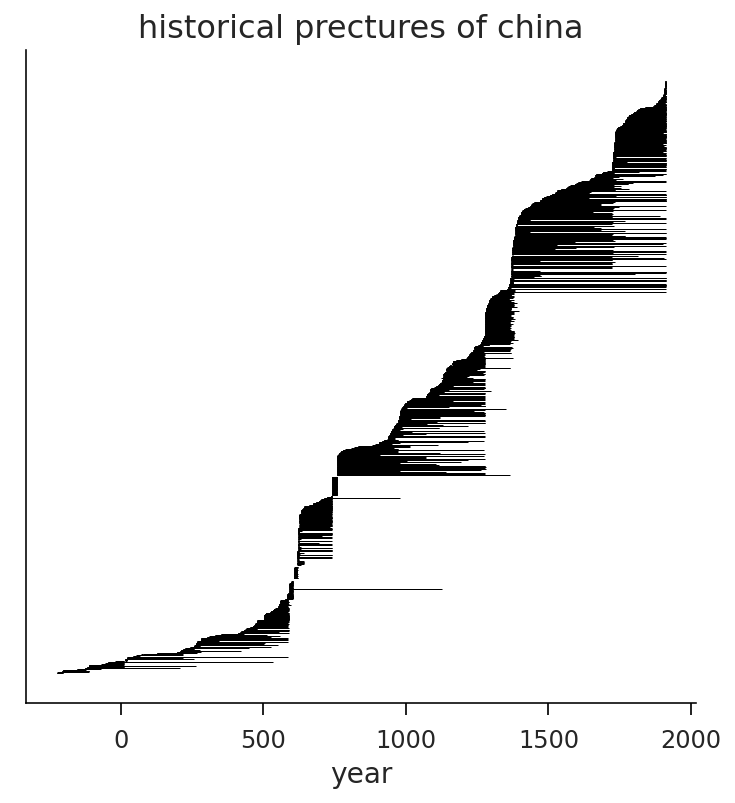

In [100]:
fig, ax = plt.subplots(figsize=(6, 6))
pref_range = pref_hist.sort_values('beg_yr')[['beg_yr', 'end_yr']].set_index(np.arange(len(pref_hist)))
for (i, (b, e)) in pref_range.iterrows():
    ax.hlines(i, b, e, linewidth=0.5)
ax.yaxis.set_visible(False);
ax.set_xlabel('year');
ax.set_title('historical prectures of china');

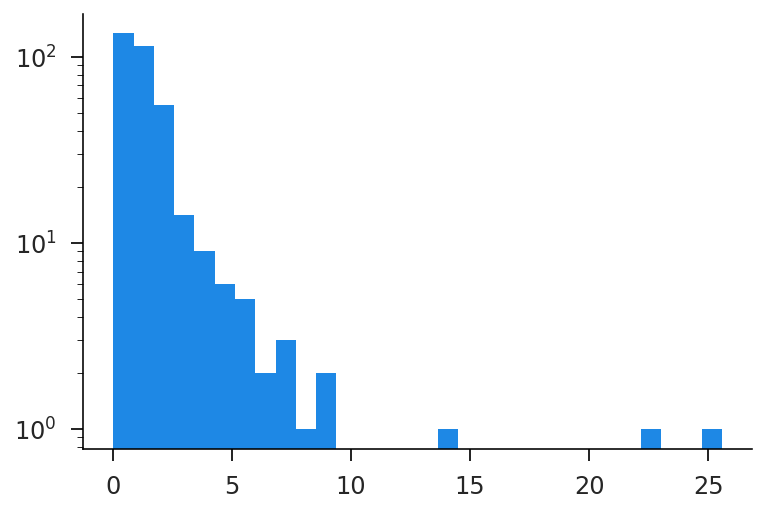

In [101]:
pref_hist.query('end_yr == 1911').area.hist(log=True, bins=30, grid=False);

### Advanced

In [102]:
year = 1776
pref_old = pref_hist.query(f'beg_yr <= {year} and end_yr >= {year}')
pref_old = pref_old[pref_old.is_valid]
pref_old.head()

,name_zh,name_en,beg_yr,end_yr,geometry
2,霍州,Huo Zhou,1772,1911,"MULTIPOLYGON (((111.85910 36.44626, 111.86777 ..."
184,郧阳府,Yunyang Fu,1476,1911,"POLYGON ((110.91881 31.66655, 110.90642 31.662..."
185,襄阳府,Xiangyang Fu,1476,1911,"POLYGON ((112.65113 31.66701, 112.65419 31.657..."
186,德安府,De'an Fu,1729,1911,"POLYGON ((113.91801 31.39151, 113.91645 31.384..."
187,汉阳府,Hanyang Fu,1763,1911,"POLYGON ((114.35085 30.68763, 114.35251 30.686..."


In [103]:
pref_new = gpd.read_file('/media/totoro/data/china_maps/modern/CHN_adm2.shp')
pref_new = pref_new.rename(columns={
    'NL_NAME_2': 'name_zh',
    'VARNAME_2': 'name_en',
})[['name_zh', 'name_en', 'geometry']]
pref_new.head()

,name_zh,name_en,geometry
0,安庆市,Ānqìng,"POLYGON ((117.11557 31.16616, 117.11788 31.160..."
1,蚌埠市,Bèngbù,"POLYGON ((117.26205 33.49959, 117.28395 33.497..."
2,亳州市,Bózhōu,"POLYGON ((115.73950 34.07428, 115.74284 34.072..."
3,巢湖市,Cháohú,"POLYGON ((118.36978 31.92897, 118.37383 31.924..."
4,池州市,Chízhōu,"POLYGON ((117.97800 30.82234, 117.97175 30.816..."


In [104]:
# choose a random modern prefecture
pref_samp = pref_new.query('name_zh == "成都市"')
name_zh, name_en = pref_samp.iloc[0][['name_zh', 'name_en']]
print(name_zh, name_en)

成都市 Chéngdū


In [106]:
# efficiently find the intersection with old provinces
xmin, ymin, xmax, ymax = pref_samp.iloc[[0]].total_bounds
old_subset = pref_old.cx[xmin:xmax, ymin:ymax]
print(len(old_subset))
inter = gpd.overlay(old_subset[['name_en', 'name_zh', 'geometry']], pref_samp, how='intersection')
print(inter[['name_en_1', 'name_zh_1']].drop_duplicates())

9
      name_en_1 name_zh_1
0       Zi Zhou        资州
1    Chengdu Lu       成都府
2  Tongchuan Fu       潼川府
3      Mei Zhou        眉州
4    Qiong Zhou        邛州
5      Mao Zhou        茂州
6     Yazhou Fu       雅州府


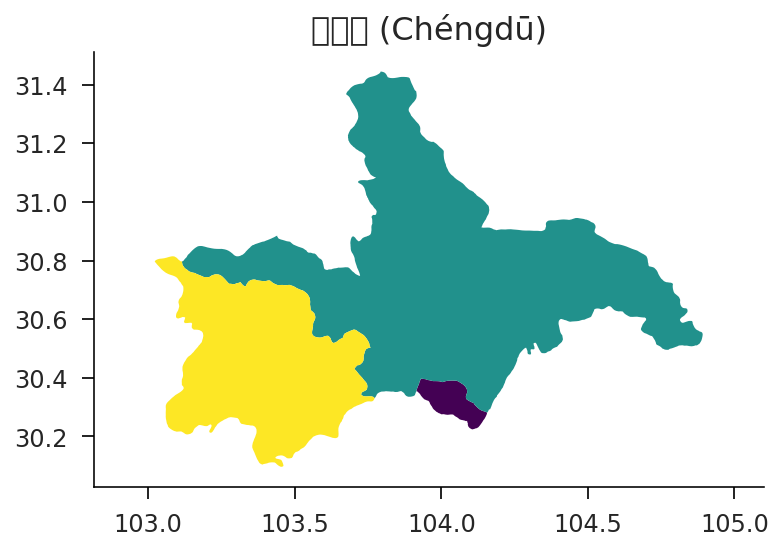

In [107]:
inter1 = inter[inter.area>0.001]
inter1['index'] = np.arange(len(inter1))
inter1.plot(column='index', cmap='viridis');
plt.title(f'{name_zh} ({name_en})');
plt.axis('equal');